# Sort spikes and make rasters

For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'
N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

if 'pakhi' in socket.gethostname():
    os.environ["KILOSORT3_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'

if 'pouli' in socket.gethostname():
    os.environ["KILOSORT3_PATH"] = '/home/pouli/repos/Kilosort'

2022-05-17 18:45:01,053 root         INFO     Running on pakhi


In [2]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

from ceciestunepipe.pipeline import searchbout as sb

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2022-05-17 18:45:06,396 root         INFO     all modules loaded


### Session parameters and raw files

In [3]:
reload(et)

bird = 's_b1238_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [11]:
reload(et)

sess_par = {'bird': 's_b1238_22',
           'sess': '2022-01-19',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [27]:
#alsa_bout_folder = '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/alsa/bouts_ceciestunepipe' 

alsa_bout_df = pd.read_pickle(os.path.join(alsa_bout_folder, 'bout_checked.pickle'))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/alsa/bouts_ceciestunepipe/bout_checked.pickle'

In [26]:
alsa_bout_df.index.size

17

In [13]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2022-05-17 18:46:45,915 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1238_22', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx', 'kwik': '/scratch/earneodo/s_b1238_22/sglx/kwik/2022-01-19', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1238_22/2022-01-19/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1238_22/sglx/msort/2022-01-19', 'ksort': '/scratch/earneodo/s_b1238_22/sglx/ksort/2022-01-19/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/s_b1238_22/sglx/ksort/2022-01-19/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx/rig.json', 'kwd': '/scratch/

['0355_nightstim_g0', '0711_g0', '1113_g0', '1545_g0']

In [15]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[1] # g2 is the shortest
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [16]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/0711_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/0711_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx/0711_g0',
  'kwik': '/scratch/earneodo/s_b1238_22/sglx/kwik/2022-01-19/0711_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1238_22/2022-01-19/sglx/0711_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/sglx/0711_g0',
  'tmp': '/scratch/earneodo/tmp/0711_g0',
  'msort': '/scratch/earneodo/s_b1238_22/sglx/msort/2022-01-19/0711_g0',
  'ksort': '/scratch/earneodo/s_b1238_22/sglx/ksort/2022-01-19/0711_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/sglx/0711_g0/sort_0'},
 'files': {'par': '/scratch/earneodo/s_b1238_22/sglx/ksort/2022-01-19/0711_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-0

In [17]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx/0711_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx/0711_g0/0711_g0_imec0'}

In [18]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx/0711_g0/0711_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx/0711_g0/0711_g0_imec0/0711_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-19/sglx/0711_g0/0711_g0_imec0/0711_g0_t0.imec0.ap.meta']}

In [19]:
files_pd = pd.DataFrame(sgl_files)

### load epoch files

In [20]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
#probe_data_folder = sgl_folder['imec'][probe_id]


In [21]:
run_recordings

{'nidq': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f8d7111b880>,
 'lf_0': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f8d71155400>,
 'ap_0': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f8d714b8b50>}

### Sync signals
(starts in a process, will let know when done. The idea is that it can run while spike sorting, if its long)

In [22]:
# all the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) + ['wav']

#all_streams = ['lf_0', 'ap_0', 'nidq']
#all_streams = ['ap_0', 'wav']
all_syn_dict = {k: sy.get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

sync_p = Process(target=sy.sync_all, args=(all_syn_dict, sess_par['ref_stream']), 
                 kwargs={'force': False}
                )
sync_p.start()

2022-05-17 18:47:02,333 ceciestunepipe.util.sglxsync INFO     getting syn patterns for nidq
2022-05-17 18:47:02,355 ceciestunepipe.util.sglxsync INFO     File /mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/sglx/0711_g0/nidq_sync_dict.pkl not found or forced computation, getting the events
2022-05-17 18:47:02,360 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan 0
2022-05-17 18:47:46,890 ceciestunepipe.util.sglxsync INFO     saving events array to /mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/sglx/0711_g0/nidq_sync_evt.npy


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/sglx/0711_g0/nidq_sync_evt.npy'

## The sorting

- invoke the recording extractor where the probe is
- quickly check data (chans look ok?)
- set parameters
- use the recording extractor and the function to sort with kilosort
- ALTERNATIVELY: do the manual curation
- Load the spikes using the functions from ceciestunepipe

##### pick one ap stream, view it after running some of the toolkits

###### view it raw

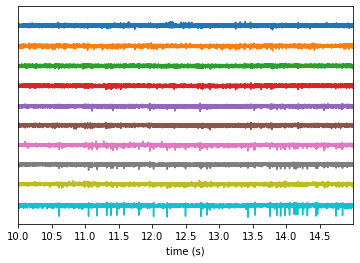

In [15]:
sw.plot_timeseries(run_recordings['ap_0'], channel_ids=range(40, 50), trange=[10,15])

###### filtered

In [16]:
# ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
# sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[10,15])

###### cmr

In [17]:
# ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
# sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(45, 55), trange=[10,15])

In [18]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/0605_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-27/0605_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1238_22/2022-01-27/sglx/0605_g0',
 'kwik': '/scratch/earneodo/s_b1238_22/sglx/kwik/2022-01-27/0605_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1238_22/2022-01-27/sglx/0605_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-27/sglx/0605_g0',
 'tmp': '/scratch/earneodo/tmp/0605_g0',
 'msort': '/scratch/earneodo/s_b1238_22/sglx/msort/2022-01-27/0605_g0',
 'ksort': '/scratch/earneodo/s_b1238_22/sglx/ksort/2022-01-27/0605_g0/sort_0',
 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-27/sglx/0605_g0/sort_0'}

In [19]:
ss.__version__

'0.4.5'

In [20]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [21]:
default_ks3_params = ss.Kilosort3Sorter.default_params()
default_ks3_params

{'detect_threshold': 6,
 'projection_threshold': [9, 9],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 300,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500}

##### manually enter ksort params

In [22]:
ks_params = {'minFR': 0.001,
             'minfr_goodchannels': 0.001}

#### run the spike sort

In [23]:
reload(ks)

<module 'ceciestunepipe.util.spike.kilosort' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py'>

In [24]:
exp_struct['folders']['ksort']

'/scratch/earneodo/s_b1238_22/sglx/ksort/2022-01-27/0605_g0/sort_0'

In [25]:
## 
tmp_loc = os.path.join(exp_struct['folders']['ksort'])

sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle')
def do_sort():
    return ks.run_spikesort(run_recordings['ap_0'], logger, sort_pickle_path, tmp_loc, restrict_to_gpu=0, 
                     sorting_method='kilosort3', chunk_mb=8192, force_redo=False,
                     **ks_params)

sort_p = Process(target=do_sort)
sort_p.start()

2022-05-15 11:52:59,513 root         INFO     Grouping property: None
2022-05-15 11:52:59,518 root         INFO     sorting method: kilosort3
2022-05-15 11:52:59,519 root         INFO     Will set visible gpu devices 0
2022-05-15 11:52:59,520 root         INFO     Sorting tmp dir /scratch/earneodo/s_b1238_22/sglx/ksort/2022-01-27/0605_g0/sort_0/tmp_ks3
2022-05-15 11:52:59,523 root         INFO     Previous sort not found, sorting
Writing to binary .dat file: 100%|##########| 59/59 [1:13:27<00:00, 74.71s/it] 


kilosort3 run time 19869.24s


Process Process-2:
Traceback (most recent call last):
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-25-dbbab100c661>", line 6, in do_sort
    return ks.run_spikesort(run_recordings['ap_0'], logger, sort_pickle_path, tmp_loc, restrict_to_gpu=0,
  File "/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py", line 170, in run_spikesort
    sort = ss.run_kilosort3(
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/spikesorters/sorterlist.py", line 527, in run_kilosort3
    return run_sorter('kilosort3', *args, **kwargs)
  File "/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/spikesorters/sorterlist.py", line 94, in run_sorter
    sortingextractor = sorter.get_result(raise_

### interlude: process the segmented, curated bouts

In [23]:
hparams, bout_pd = sb.load_bouts(sess_par['bird'], sess_par['sess'], '', 
                                 derived_folder = 'bouts_sglx', bout_file_key='bout_curated_file')

2022-05-17 18:48:02,816 ceciestunepipe.pipeline.searchbout INFO     Search parameters file not found /mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-19/bouts_sglx/bout_search_params.pickle


In [29]:
### filter_by epoch
logger.info('filtering only good bouts from this epoch {}'.format(sess_par['epoch']))

## drop bouts that are not from the session OR that are not bout_check

drop_condition = (~bout_pd['file'].str.contains(sess_par['epoch'])) | (bout_pd['bout_check']==False)

bout_pd.drop(bout_pd[drop_condition].index, inplace=True)
bout_pd.reset_index(drop=True, inplace=True)

2022-05-16 07:18:35,372 root         INFO     filtering only good bouts from this epoch 0605_g0


In [30]:
bout_pd.index.size

71

#### load the sync
(running sync_all with force=False, it should load whatever computed in the process it ran above.)

In [31]:
sy.sync_all(all_syn_dict, sess_par['ref_stream'], force=False)

2022-05-16 07:18:42,490 ceciestunepipe.util.sglxsync INFO     syncing all times to ap_0
2022-05-16 07:18:42,491 ceciestunepipe.util.sglxsync INFO      synch nidq...
2022-05-16 07:18:42,804 ceciestunepipe.util.sglxsync INFO      synch lf_0...
2022-05-16 07:18:42,890 ceciestunepipe.util.sglxsync INFO      synch wav...
2022-05-16 07:18:42,968 ceciestunepipe.util.sglxsync INFO     Done with sync_all


##### sync all the trial timestams to the spike time base (ap_0 from the imec data)

In [32]:
reload(sy)
bout_dict, bout_syn_pd = sy.bout_dict_from_pd(bout_pd, all_syn_dict, s_f_key='wav')

In [40]:
bout_syn_pd.head(2)

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,...,n_peaks,l_p_ratio,waveform,confusing,valid_waveform,valid,spectrogram,start_ms_ap_0,start_sample_ap_0,start_sample_naive
0,8928142,8974777,357125680,358991080,"[5.917822110459767, 9.514300568213836, 6.84554...",15.251134,272.385183,True,/mnt/sphere/speech_bci/derived_data/s_b1238_22...,46635,...,580,80.405172,"[22, 28, 15, 0, 14, 14, 7, -1, -7, 11, 7, 1, 8...",False,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",8.928298e+06,267849438,357125680
1,12924783,12969388,516991320,518775520,"[4.5237089374359405, 5.084839802884067, 5.9880...",17.366638,255.607165,True,/mnt/sphere/speech_bci/derived_data/s_b1238_22...,44605,...,568,78.529930,"[77, 71, 60, 57, 47, 48, 42, 45, 35, 38, 47, 4...",False,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.292501e+07,387750955,516991320


### Save the bout/mot/trial data

In [33]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'bout_dict_ap0.pkl')
bout_pd_path = os.path.join(exp_struct['folders']['derived'], 'bout_pd_ap0.pkl')

with open(bout_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)
    
bout_pd.to_pickle(bout_pd_path)

logger.info('saved syncronized bout dict and pandas dataframe to {}, {}'.format(bout_dict_path, bout_pd_path))

2022-05-16 07:24:53,593 root         INFO     saved syncronized bout dict and pandas dataframe to /mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-27/sglx/0605_g0/bout_dict_ap0.pkl, /mnt/sphere/speech_bci/derived_data/s_b1238_22/2022-01-27/sglx/0605_g0/bout_pd_ap0.pkl


#### load the sort

In [34]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))
spk_df.head(1)

,times,clusters,cluster_id
0,90,620,620


In [35]:
clu_df.head(1)

,cluster_id,KSLabel,group,MSLabel,has_template,template,max_chans,main_chan,main_7,main_wav_7
6,6,good,good,None,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[13, 11, 12, 10, 9, 15, 8, 14, 7, 5, 16, 6, 17...",13,"[8, 9, 10, 11, 12, 13, 15]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."


In [36]:
# count the good ones
np.unique(clu_df[clu_df['KSLabel']=='good']['cluster_id']).size

391

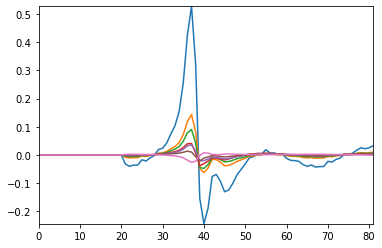

In [37]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

### Visualize a bout together with the neural traces

In [38]:
plt.rcParams['lines.linewidth'] = 0.1

In [39]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [40]:
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

In [41]:
ap_sf = all_syn_dict['ap_0']['s_f']

### one example of bout onset

In [57]:
## call the HVC/RA sites
ra_chans = range(118, 202)
neur_chans = ra_chans

clu_df['nucleus'] = np.nan
#clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'
#clu_df.loc[clu_df['main_chan'].isin(neur_chans), 'nucleus'] = 'ncm'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

In [58]:
mot_idx = 20

mot_start_wav = bout_dict['start_sample_wav'][mot_idx]
mot_start_ap = bout_dict['start_sample_ap_0'][mot_idx]

pre_sec = -2.25
post_sec = 45 - pre_sec

ap_sf = all_syn_dict['ap_0']['s_f']

mic_arr = mic_stream[mot_start_wav + int(pre_sec*s_f_wav): mot_start_wav + int(post_sec*s_f_wav)]

ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

<ipython-input-59-12a952a9720b>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


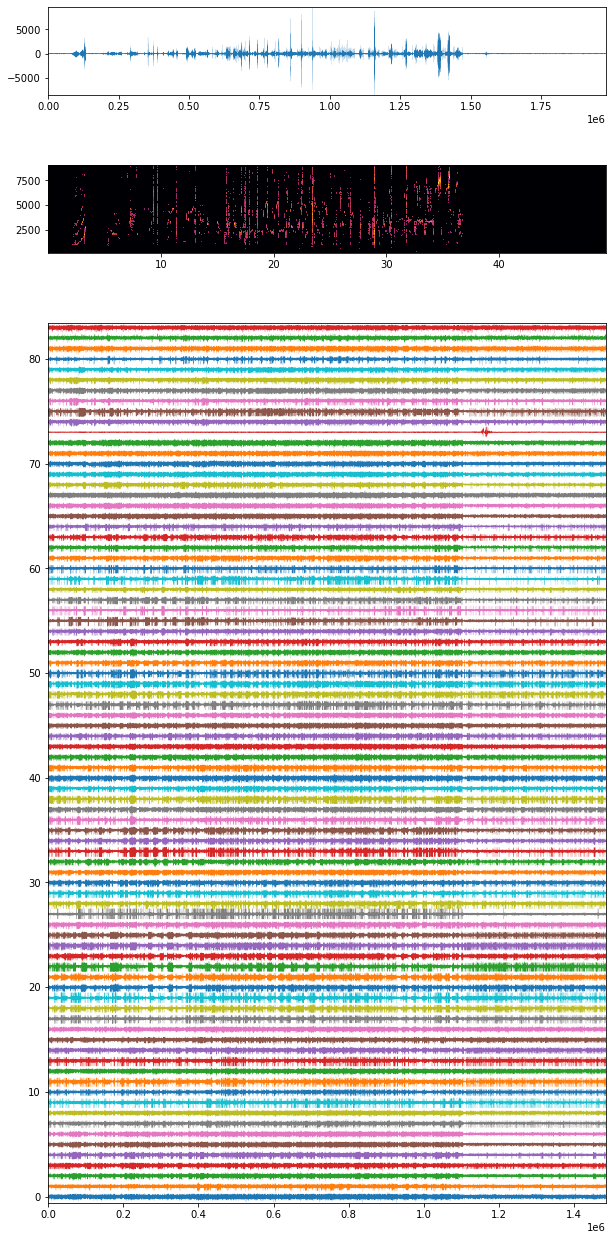

In [59]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

In [60]:
## get the actural raster for some clusters
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

t_pre = - 2
t_post = 2

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = mot_idx
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)
    

spk_arr = ks.get_window_spikes(spk_df, clu_list, start_ap , end_ap)


#rast_arr = ks.get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:99: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [61]:
clu_list.size

99

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


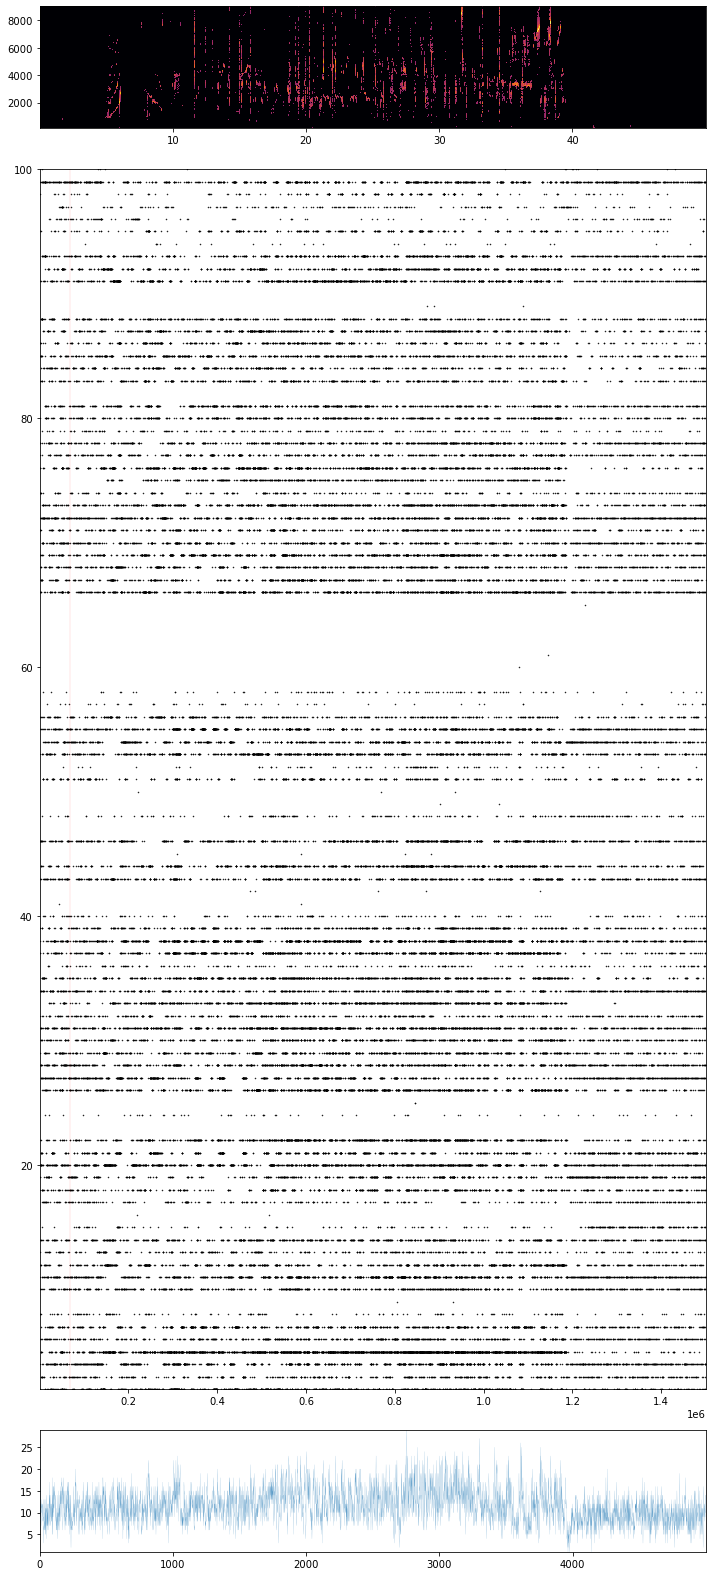

In [63]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 5
t_post = 45

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = mot_idx
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = ks.get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [64]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
#fig.savefig(fig_path+'.eps')

### save cluster and cluster metadata

In [65]:
# clu_df['nucleus'] = np.nan
# clu_df.loc[clu_df['main_chan'].isin(neur_chans), 'nucleus'] = 'ncm'

sort_folder = os.path.join(exp_struct['folders']['derived'], sess_par['sort'])
os.makedirs(sort_folder, mode=0o777, exist_ok=True)

clu_df_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pickle')
spk_df.to_pickle(spk_df_path)

### Now done this, this notebooks has generated:

- Spike sorted data:
    (with quality of sort (be auto or manually in 'MSlabel/KSlabel'))
    clu_df.pickle and spk_df.pickle in 
    /mnt/sphere/speech_bci/derived_data/bird/sess/sglx/epoch/sort_id
    
- behavior data, synchronized to the ap_0 channel:
    bout_pd_ap0.pkl and bout_dict_ap0.pkl
    /mnt/sphere/speech_bci/derived_data/bird/sess/sglx/epoch/
    